In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import glob, json, tqdm
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from collections import defaultdict
from functools import partial
from multiprocessing import Pool
from tqdm.contrib.concurrent import process_map

In [2]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
NCOLS = 4
SUFFIX = 2020
SUFFIX_STR = '_%d' % SUFFIX

In [3]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [20]:
# pairs_authors_dd = dd.read_csv('data/pair_csv_%d_byAuthorIDprocessed_pairs.csv' % SUFFIX, sep='\t', header=None, names=['author_id', 'cits'])
# pairs_authors_dd = dd.read_csv('data/pair_csv_10a_%dmerged_processed.csv' % SUFFIX, sep='\t', header=None, names=['author_id', 'cits'])
pairs_authors_dd = dd.read_csv('data/PairAuthors2csv_split/pair_csv_year_10a_%d_   *' % SUFFIX, sep='\t', header=None, names=['author_id', 'cits'])
pairs_authors_dd = pairs_authors_dd.set_index('author_id', sorted=True)
pairs_authors_dd.head()

,cits
author_id,
5211,"{""1141255472"": [14], ""1970691061"": [0, 0, 1, 4..."
6478,"{""1278312360"": [10, 23, 8], ""1397579107"": [23,..."
11720,"{""1214880279"": [35, 41, 24], ""1250321752"": [15..."
15251,"{""105506866"": [93], ""1061427020"": [33, 93], ""1..."
16490,"{""1355423769"": [0, 3, 0, 13, 2], ""14095309"": [..."


In [21]:
authors_infos = dd.read_csv('data/authors_infos_full_10a_final_%d' % SUFFIX, sep='\t', header=None, 
                            names=['author_id', 'birth_year', 'citation_count'])
authors_infos = authors_infos.set_index('author_id', sorted=True)
authors_infos.head()

,birth_year,citation_count
author_id,,
5211,2005,"[0, 96.0, 40.0, 46.0, 69.0, 24.0, 13.0, 43.0, ..."
6478,1994,"[43.0, 3.0, 0, 1.0, 6.0, 1.0, 21.0, 0, 8.0, 1...."
11720,1999,"[2.0, 42.0, 2.0, 17.0, 29.0, 14.0, 0, 17.0, 42..."
15251,1995,"[69.0, 38.0, 23.0, 65.0, 93.0, 0, 70.0, 43.0, ..."
16490,1998,"[0, 1.0, 0, 0, 6.0, 0, 2.0, 0, 1.0, 0, 0, 0, 5..."


In [22]:
pairs_authors_dd2 = pairs_authors_dd.merge(authors_infos, left_index=True, right_index=True)
pairs_authors_dd2.head()

,cits,birth_year,citation_count
author_id,,,
5211,"{""1141255472"": [14], ""1970691061"": [0, 0, 1, 4...",2005,"[0, 96.0, 40.0, 46.0, 69.0, 24.0, 13.0, 43.0, ..."
6478,"{""1278312360"": [10, 23, 8], ""1397579107"": [23,...",1994,"[43.0, 3.0, 0, 1.0, 6.0, 1.0, 21.0, 0, 8.0, 1...."
11720,"{""1214880279"": [35, 41, 24], ""1250321752"": [15...",1999,"[2.0, 42.0, 2.0, 17.0, 29.0, 14.0, 0, 17.0, 42..."
15251,"{""105506866"": [93], ""1061427020"": [33, 93], ""1...",1995,"[69.0, 38.0, 23.0, 65.0, 93.0, 0, 70.0, 43.0, ..."
16490,"{""1355423769"": [0, 3, 0, 13, 2], ""14095309"": [...",1998,"[0, 1.0, 0, 0, 6.0, 0, 2.0, 0, 1.0, 0, 0, 0, 5..."


In [23]:
authors_fos = dd.read_csv('data/valid_authors_%d_fos_10a_full.csv' % SUFFIX, sep='\t', header=None, 
                          names=['author_id', 'weights', 'fos'], dtype={'fos': 'float64'})

# authors_fos = authors_fos.set_index('author_id', sorted=True)

authors_fos.head()

,author_id,weights,fos
0,5211,"{""185592680"": 2.5528422503422505, ""192562407"":...",86803240.0
1,6478,"{""121332964"": 0.10876623376623376, ""71924100"":...",86803240.0
2,11720,"{""121332964"": 6.0506721056721045, ""185592680"":...",185592680.0
3,15251,"{""127313418"": 0.39979657687991027, ""86803240"":...",86803240.0
4,16490,"{""121332964"": 3.018797061524334, ""205649164"": ...",86803240.0


In [24]:
len(authors_fos)

2633341

In [102]:
len(authors_fos['author_id'].unique())

2633343

In [25]:
authors_complete = pairs_authors_dd2.merge(authors_fos, on='author_id')
authors_complete.head(5)

,author_id,cits,birth_year,citation_count,weights,fos
0,2616390428,"{""1178076191"": [0, 0, 12, 1], ""1636865778"": [1...",1997,"[42.0, 1.0, 21.0, 5.0, 29.0, 381.0, 0, 2.0, 28...","{""121332964"": 7.235931765300553, ""127313418"": ...",127413603.0
1,2616917672,"{""1228500020"": [0], ""1276142888"": [1], ""136144...",1983,"[1.0, 0, 11.0, 9.0, 51.0, 308.0, 0, 0, 10.0, 0...","{""127413603"": 1.09650750252254, ""33923547"": 1....",71924100.0
2,2616918103,"{""1010813668"": [2], ""1824135441"": [1, 2, 3], ""...",1999,"[724.0, 28.0, 45.0, 388.0, 17.0, 130.0, 44.0, ...","{""121332964"": 2.0422101972101974, ""192562407"":...",86803240.0
3,2616941960,"{""1125519048"": [0, 10, 1, 46, 4, 7], ""19758941...",1972,"[45.0, 13.0, 9.0, 2.0, 42.0, 10.0, 12.0, 0, 3....","{""121332964"": 0.2526809764309765, ""192562407"":...",86803240.0
4,2616956517,"{""1809694980"": [6, 9], ""1957720414"": [13], ""20...",2004,"[0, 0, 2.0, 0, 0, 0, 11.0, 17.0, 1.0, 13.0, 12...","{""127413603"": 2.2079316979316985, ""192562407"":...",86803240.0


In [26]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    authors_complete.to_csv('data/AuthorsMetrics_split/authors_metrics_full_10a_%d' % SUFFIX, sep='\t', header=None, index=None, single_file=True)

[########################################] | 100% Completed |  6min  4.7s


In [4]:
from s4_authors_stats import _step_1

authors_complete = dd.read_csv('data/AuthorsMetrics_split/authors_metrics_full_10a_%d' % SUFFIX, sep='\t', header=None)
authors_complete.columns = ['author_id', 'cits', 'birth_year', 'citation_count', 'weights', 'fos']

def sum_cits(row):
    c = sum(json.loads(row['citation_count']))
    return c

authors_complete = authors_complete[authors_complete.apply(sum_cits, meta=(int), axis=1) > 0]
authors_complete.head()
# print(authors_complete.head())

,author_id,cits,birth_year,citation_count,weights,fos
0,2632943989,"{""1822016271"": [0, 125, 29, 43, 70], ""20549333...",1981,"[0, 0, 0, 0, 0, 0, 11.0, 19.0, 125.0, 15.0, 13...","{""144024400"": 0.13181818181818183, ""17744445"":...",71924100.0
1,2632944995,"{""2463522222"": [42], ""2616990729"": [15, 94], ""...",1990,"[42.0, 15.0, 29.0, 9.0, 94.0, 20.0, 0, 5.0, 3....","{""138885662"": 0.8166666666666667, ""142362112"":...",71924100.0
2,2633122112,"{""1527925734"": [0, 0, 2], ""1749860532"": [0, 1,...",1983,"[0, 0, 3.0, 0, 2.0, 0, 0, 4.0, 92.0, 25.0, 1.0...","{""121332964"": 55.08896947967504, ""33923547"": 3...",121332964.0
3,2633175297,"{""1159606036"": [43], ""1924744707"": [75], ""1994...",2003,"[30.0, 29.0, 36.0, 29.0, 78.0, 8.0, 47.0, 75.0...","{""121332964"": 2.3217493112947656, ""192562407"":...",185592680.0
4,2633712990,"{""1822742569"": [0, 0, 7], ""1847239135"": [113],...",2010,"[14.0, 113.0, 0, 3.0, 0, 0, 0, 1.0, 7.0, 8.0, ...","{""15744967"": 0.40454545454545465, ""71924100"": ...",71924100.0


In [ ]:
H, C, P, WS, WP, CL, Y, CH, FOS = s4.step_1(authors_complete)

In [29]:
len(authors_complete['author_id'].unique())

2630275

In [30]:
open('results/hindex_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(H))
open('results/cits_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(C))
open('results/papers_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(P))
open('results/ws_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(WS))
open('results/wp_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(WP))
open('results/citlist_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(CL))
open('results/birth_10a_full_%d.json' % SUFFIX, 'w').write(json.dumps(Y))
open('results/fos_10a_full_%d.json' % SUFFIX,'w').write(json.dumps(FOS))
open('results/ch_10a_full_%d.json' % SUFFIX, 'w').write(json.dumps(CH))

744352964

### Some statistics...

In [7]:
def cit_count(data):
    return data.apply(lambda x: x.cits.count('['), meta=(int), axis=1)
    
colabs_per_author = authors_complete.assign(n_authors=cit_count)[['author_id', 'fos', 'n_authors']]

print(colabs_per_author.head())

results = colabs_per_author.groupby('fos')['n_authors'].apply(list, meta=('n_authors_per_fos', object))

    author_id          fos  n_authors
0  2632943989   71924100.0         27
1  2632944995   71924100.0         10
2  2633122112  121332964.0        100
3  2633175297  185592680.0         38
4  2633712990   71924100.0         53


['/mnt/e/Ana/author_dep/colabs_per_author_results.csv']

    Unnamed: 0                                  n_authors_per_fos
0   71924100.0  [57, 66, 172, 232, 28, 74, 96, 135, 166, 116, ...
1  144133560.0  [69, 40, 41, 66, 40, 50, 19, 51, 3, 40, 33, 10...
2  185592680.0  [141, 169, 71, 101, 11, 53, 43, 118, 30, 71, 3...
3  138885662.0  [15, 23, 48, 124, 32, 30, 5, 2, 8, 9, 5, 5, 18...
4   41008148.0  [74, 25, 22, 5, 76, 20, 122, 44, 112, 67, 13, ...
history 22.406 27.388
art 26.496 36.187
philosophy 21.068 26.452
sociology 22.177 26.208
political science 24.719 29.772
population 34.081 40.590
economics 30.021 36.258
mathematics 34.169 42.648
business 29.660 35.099
geology 76.280 89.422
psychology 43.658 53.727
geography 56.792 65.887
engineering 46.300 57.010
computer science 47.405 58.816
environmental science 58.489 68.571
physics 68.416 84.319
medicine 91.420 112.763
biology 71.278 87.521
chemistry 63.759 80.599
materials science 63.823 79.731


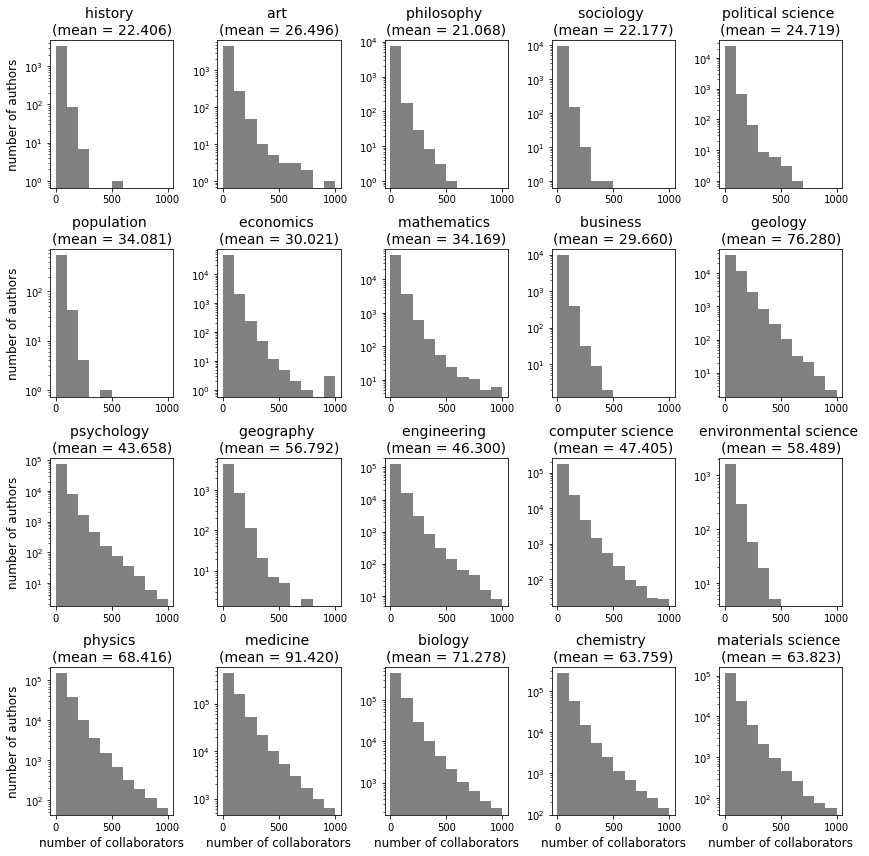

In [40]:
fos_sorted = [95457728.0, 142362112.0, 138885662.0, 144024400.0, 17744445.0, 2908647359.0, 
              162324750.0, 33923547.0, 144133560.0, 127313418.0, 15744967.0, 205649164.0,
              127413603.0, 41008148.0, 39432304.0, 121332964.0, 71924100.0, 86803240.0, 185592680.0, 192562407.0]
results = pd.read_csv('colabs_per_author_results.csv', sep='\t')
print(results.head())
fig,axes = plt.subplots(figsize=(12, 12), nrows=4, ncols=5)
i = 0
axes = axes.ravel()

for f in fos_sorted:

    for idx, row in results.iterrows():
        field = row[0]
        if f == field:
            fos_dist = json.loads(row['n_authors_per_fos'])
            axes[i].hist(fos_dist, range=(0, 1000), color='gray')
            field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
            fos_dist = np.asarray(fos_dist)
            p95 = np.percentile(fos_dist, 95)
            M = np.mean(fos_dist[fos_dist < p95])
            print("%s %.3f %.3f" % (field_name, M, np.mean(fos_dist)))
            if i % 5 == 0:
                axes[i].set_ylabel('number of authors', fontsize=12)
            if i >= 15:
                axes[i].set_xlabel('number of collaborators', fontsize=12)
            
            axes[i].set_yscale('log')
            axes[i].set_title("%s \n(mean = %.3f)" % (field_name, M), fontsize=14)
            i += 1
    
plt.tight_layout()
plt.savefig('number_of_colabs_per_fos_%d_percentile95.pdf' % SUFFIX)

In [33]:
for current_year in [1960, 1970, 1980, 1990, 2000, 2010, 2020]:
    colabs_cits = json.load(open('results/citlist_10a_full_%d.json' % current_year))
    count_no_colabs = 0
    for temp in colabs_cits:
        if len(temp) == 0:
            count_no_colabs += 1
    print("%d & %.2f\%% & %d" % (current_year, 100*count_no_colabs/len(colabs_cits), count_no_colabs))

1960 & 1.44\% & 550
1970 & 0.94\% & 1154
1980 & 0.64\% & 2120
1990 & 0.40\% & 3019
2000 & 0.21\% & 3110
2010 & 0.06\% & 1569
2020 & 0.02\% & 627


In [9]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    authors_per_fos = authors_complete.groupby('fos')['author_id'].count().compute()
    print(authors_per_fos)

[########################################] | 100% Completed | 53.9s
fos
15744967       46526
17744445       13171
33923547       29595
39432304         977
41008148      101553
71924100      352031
86803240      300340
95457728        1573
121332964      86921
127313418      25085
127413603      66732
138885662       4048
142362112       2255
144024400       5163
144133560       5338
162324750      25625
185592680     158762
192562407      60771
205649164       2677
2908647359       274
Name: author_id, dtype: int64


In [ ]:
files = glob.glob('data_temp/FOS_split/fields_papers_*.csv')

def to_process_papers(file):
    papers_fos_dict = defaultdict(lambda:set())
    papers_per_fos = pd.read_csv(file, header=None)[[1, 6]]
    papers_per_fos.columns = ['paper_id', 'parents_id']
    papers_per_fos = papers_per_fos.dropna()
    for idx,row in papers_per_fos.iterrows():
        for fos in row['parents_id'].split(','):
            papers_fos_dict[fos].add(row['paper_id'])
            
    return papers_fos_dict
from multiprocessing import Pool

output_maps = process_map(to_process_papers, files, max_workers=16) 